In [8]:
from lib.threshold_tree import ThresholdTree
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create dataset and perform Clustering

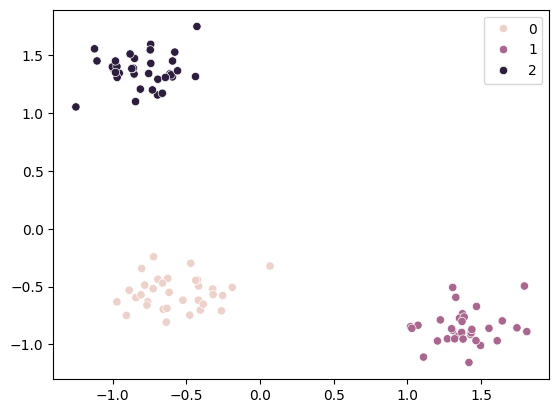

[[ 1.7432752  -0.85729795]
 [-0.9057402  -0.75045031]
 [-0.99197451  1.38013227]
 [-0.61066161  1.33995556]
 [-1.00107474  1.39981399]
 [-0.72412392 -0.51926081]
 [-0.41653447 -0.49478543]
 [ 1.27153086 -0.95260767]
 [-0.18769519 -0.50731369]
 [-0.97019034 -0.63293632]]


In [9]:
dims = 2
n = 100
k = 3
min_impurity_decrease = 0.00001
threshold_change = 0.01
robustness_factor = 0.7

X, _y = make_blobs(centers=k, cluster_std=1.2, n_features=dims, n_samples=n)
data = load_wine()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k)
model.fit(X)

centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]

# plot the clusters
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
else:
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
plt.show()

print(X[:10])

# Choose instance and target

In [10]:
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 0, point: [-0.9057402  -0.75045031]
Target center class: 2, point: [-0.79672017  1.3690497 ]



# Find cfs using Decision Tree Classifier

DTC accuracy: 1.0

Instance: [-0.9057402  -0.75045031]
Instance prediction : [0]

CFS: [[-0.9057402   0.41563651]
 [-0.9057402   1.08302574]]
CF predictions:  [2 2]


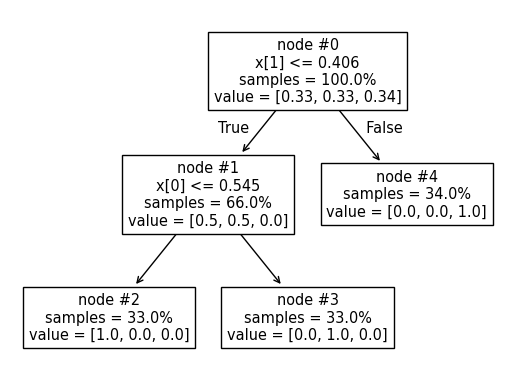

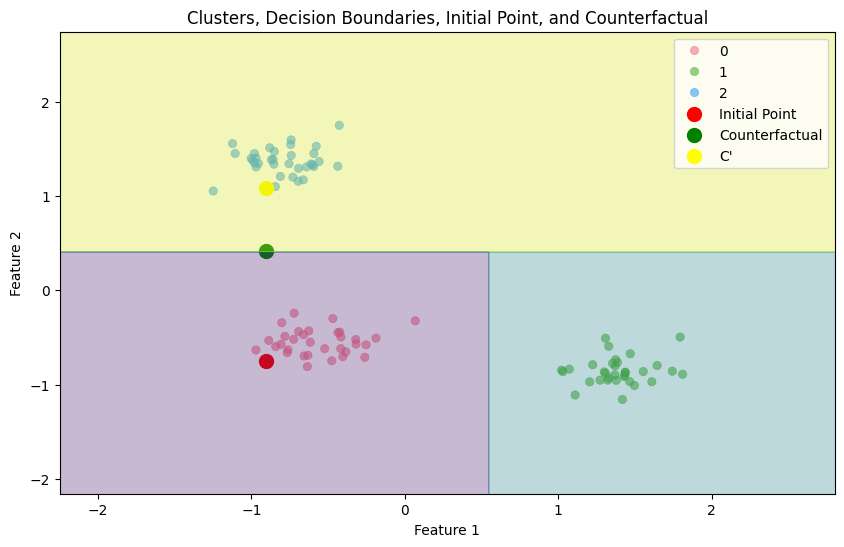

In [11]:
threshold_tree = ThresholdTree(model, centers, X, y)

cfs = threshold_tree.find_counterfactuals_DTC(instance, target_class, min_impurity_decrease=min_impurity_decrease, threshold_change=threshold_change, robustness_factor=robustness_factor)
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
threshold_tree.print_DTC_tree()
threshold_tree.plot_DTC_tree()

# Find cfs using Iterative Mistake Minimization(IMM)

Instance:  [-0.9057402  -0.75045031]
Counterfactual:  [[-0.9057402   0.41744262]]

Original class:  [0]
Counterfactual class:  [2]
├── L0: f0 < 0.2954729681564582
│   ├── L1: f1 < 0.40744261595325243
│   │   ├── L2, C: 0
│   │   └── L2, C: 2
│   └── L1, C: 1



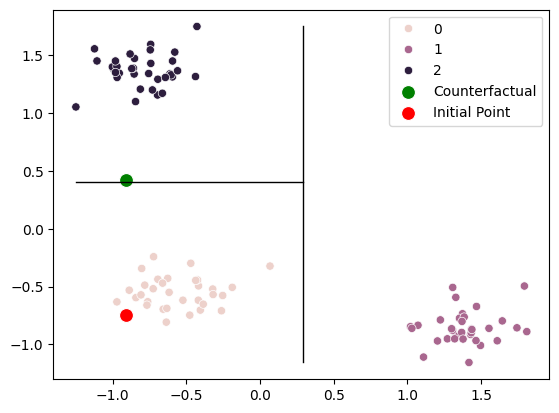

In [13]:
cf = threshold_tree.find_counterfactuals_IMM(instance, target_class, threshold_change=threshold_change)
print("Instance: ", instance)
print("Counterfactual: ", cf)
print("")
print("Original class: ", model.predict([instance]))
print("Counterfactual class: ", model.predict(cf))
threshold_tree.print_IMM_tree()
threshold_tree.plot_IMM_tree()